In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from scipy.signal import fftconvolve
from astropy.io import fits
import numpy as np
import math
from pathlib import Path
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from vacuum.model import create_model
from vacuum.io import load_data, preprocess, deprocess, fits_open

In [4]:
INPUT_DIR = "/scratch/datasets/kat7_2000/"

SEPARABLE_CONV = False   # use separable convolutions in the generator
NGF = 64                 # number of generator filters in first conv layer
NDF = 64                 # number of discriminator filters in first conv laye
BATCH_SIZE = 5           # number of images in batch
CROP_SIZE = 256
EPS = 1e-12
FLIP = False              # flip images horizontally during training
SCALE_SIZE = 256         # scale images to this size before cropping to 256x256
MAX_EPOCHS = 1           # number of training epochs
LR = 0.0002              # initial learning rate for adam
BETA1 = 0.5              # momentum term of adam
L1_WEIGHT = 100.0        # weight on L1 term for generator gradient
GAN_WEIGHT = 1.0         # weight on GAN term for generator gradient
INPUT_MULTIPLY = 1.0     # Use this to scale in the max input fluxes to about 5 Jy 
DATA_START = 1840
DATA_END = 1899

In [5]:
batch, count = load_data(INPUT_DIR, CROP_SIZE, FLIP, SCALE_SIZE, MAX_EPOCHS,
                         BATCH_SIZE, start=DATA_START, end=DATA_END)
steps_per_epoch = int(math.ceil(count / BATCH_SIZE))
iter = batch.make_one_shot_iterator()
index, min_flux, max_flux, psf, dirty, skymodel = iter.get_next()
print("examples count = %d" % count)

examples count = 59


In [6]:
scaled_dirty = preprocess(dirty, min_flux, max_flux)
scaled_skymodel = preprocess(skymodel, min_flux, max_flux)
scaled_psf = preprocess(psf, min_flux, max_flux)

In [9]:
concat = tf.concat([scaled_dirty, scaled_skymodel], axis=3)

In [14]:
concat[:,:,:,1].shape

TensorShape([Dimension(5), Dimension(256), Dimension(256)])

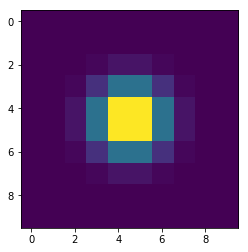

In [21]:
t = tf.linspace(-10.0, 10.0, 10)
bump = tf.exp(-0.1*t**2)
bump /= tf.reduce_max(bump) # normalize the integral to 1
kernel = bump[:, tf.newaxis] * bump[tf.newaxis, :]
plt.imshow(kernel)

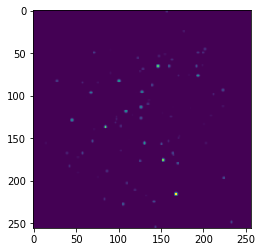

In [22]:
filter_ = tf.expand_dims(tf.expand_dims(kernel, 2), 3)
convolved = tf.nn.conv2d(skymodel, filter_, [1, 1, 1, 1], "SAME")
plt.imshow(tf.squeeze(convolved[1, :, :]))

In [14]:
skymodel[0].numpy().max()

2.34

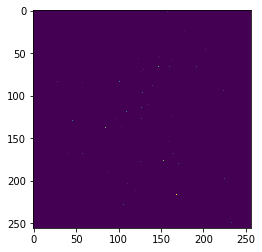

In [15]:
plt.imshow(tf.squeeze(scaled_skymodel[1, :, :]))